In [ ]:
#compare the models 

In [3]:
import os 
import re
import matplotlib.pyplot as plt
import rmgpy.chemkin
import numpy as np
import cantera as ct
import random
import pandas as pd
%matplotlib inline

In [2]:
def load_chemkin_file(path): 
    """ 
    Load Chemkin file and extract the reactions and species.
    Path should be the path to the species folder.
    """
    
    full_path = os.path.join(path,'chemkin')
    chemkin_path = os.path.join(full_path, 'copies/copy_chem_annotated.inp')
    dictionary_path = os.path.join(full_path,'species_dictionary.txt')
    transport_path = os.path.join(full_path,'tran.dat')


    species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin_path, dictionary_path=dictionary_path, transport_path=transport_path)

    return species_list, reaction_list 

In [5]:
#load the RMG models 

#RMG 

#RMG: Fluorine lib 
path_RMG_F='/work/westgroup/nora/Code/Advanced_Kinetics_Class/project/models/RMG/Fluorine_lib/chemkin'
chemkin_path = os.path.join(path_RMG_F, 'copies/copy_chem_annotated_208.inp')
dictionary_path = os.path.join(path_RMG_F,'species_dictionary.txt')
transport_path = os.path.join(path_RMG_F,'tran.dat')
spec_RMG_F, reac_RMG_F = rmgpy.chemkin.load_chemkin_file(chemkin_path, dictionary_path=dictionary_path, transport_path=transport_path)


#RMG: Needham core

path_RMG_Needham_core='/work/westgroup/nora/Code/Advanced_Kinetics_Class/project/models/RMG/Needham_core/chemkin'
chemkin_path = os.path.join(path_RMG_Needham_core, 'copies/copy_chem_248_annotated.inp')
dictionary_path = os.path.join(path_RMG_Needham_core,'species_dictionary.txt')
transport_path = os.path.join(path_RMG_Needham_core,'tran.dat')
spec_RMG_Nc, reac_RMG_Nc = rmgpy.chemkin.load_chemkin_file(chemkin_path, dictionary_path=dictionary_path, transport_path=transport_path)

#RMG: Needham core, Fluorine lib
path_RMG_Needham_core_F_lib='/work/westgroup/nora/Code/Advanced_Kinetics_Class/project/models/RMG/Needham_core_Fluorine_lib/chemkin'
chemkin_path = os.path.join(path_RMG_Needham_core_F_lib, 'copies/copy_chem_257_annotated.inp')
dictionary_path = os.path.join(path_RMG_Needham_core_F_lib,'species_dictionary.txt')
transport_path = os.path.join(path_RMG_Needham_core_F_lib,'tran.dat')
spec_RMG_Nc_F, reac_RMG_Nc_F = rmgpy.chemkin.load_chemkin_file(chemkin_path, dictionary_path=dictionary_path, transport_path=transport_path)

#RMG: Needham core, NIST lib, Fluorine lib 
#Advanced_Kinetics_Class/project/models/RMG/Needham_core_NIST_lib_Fluorine_lib

path_RMG_Needham_core_NIST_F_lib='/work/westgroup/nora/Code/Advanced_Kinetics_Class/project/models/RMG/Needham_core_NIST_lib_Fluorine_lib/chemkin'
chemkin_path = os.path.join(path_RMG_Needham_core_NIST_F_lib, 'copies/copy_chem_257_annotated.inp')
dictionary_path = os.path.join(path_RMG_Needham_core_NIST_F_lib,'species_dictionary.txt')
transport_path = os.path.join(path_RMG_Needham_core_NIST_F_lib,'tran.dat')
spec_RMG_Nc_NIST_F, reac_RMG_Nc_NIST_F = rmgpy.chemkin.load_chemkin_file(chemkin_path, dictionary_path=dictionary_path, transport_path=transport_path)



In [9]:
#load the non-RMG models

#Needham model 
path_Needham='/work/westgroup/nora/Code/Advanced_Kinetics_Class/project/models/Needham_model/'
chemkin_path = os.path.join(path_Needham, 'YF_mech_chemkin.inp')
dictionary_path = os.path.join(path_Needham,'dictionary_from_github.txt')
transport_path = os.path.join(path_Needham,'YF_Transport_Final.txt')
spec_Needham, reac_Needham = rmgpy.chemkin.load_chemkin_file(chemkin_path, dictionary_path=dictionary_path, transport_path=transport_path)

#NIST model
path_NIST='/work/westgroup/nora/Code/Advanced_Kinetics_Class/project/models/NIST_model/'
chemkin_path = os.path.join(path_NIST, 'copy_frozen3_with_thermo.inp')
dictionary_path = os.path.join(path_NIST,'dictionary_from_github.txt')
transport_path = os.path.join(path_NIST,'transport-frozen3.txt')
spec_NIST, reac_NIST = rmgpy.chemkin.load_chemkin_file(chemkin_path, dictionary_path=dictionary_path, transport_path=transport_path)



COMPARE MODELS

In [128]:
def _2_to_1(_2_reaction):
    '''
    Convert the 2nd model species in the reactions to 1st model species, but keep the 2nd model kinetics
    '''
    
    _1_reaction = copy.deepcopy(_2_reaction)
    reactants = []
    for reactant in _2_reaction.reactants:
        try:
            _2_species_index = _2_species_list.index(reactant)
            reactants.append(_1_species_list[_2_to_1_mapping[_2_species_index]])
        except ValueError:
            if reactant in _1_species_list:
                reactants.append(reactant)
        
    _1_reaction.reactants = reactants
    
    products = []
    for product in _2_reaction.products:
        try:
            _2_species_index = _2_species_list.index(product)
            products.append(_1_species_list[_2_to_1_mapping[_2_species_index]])
        except ValueError:
            if product in _1_species_list:
                products.append(product)
    _1_reaction.products = products
    
    return _1_reaction

In [129]:
def _1_to_2(_1_reaction):
    # takes in the _1_reaction object to convert
    _1_index = _1_reaction_list.index(_1_reaction)
    if _1_index not in _1_to_2_rxn_mapping.keys():
        # this reaction does not exist in 2nd model, so it will be deleted. return None
        print(f'Reaction does not match to NIST reaction: {_1_reaction.index}')
        return
    _2_index = _1_to_2_rxn_mapping[_1_index]
    _2_reaction = _2_reaction_list[_2_index]
    
    # convert the 2nd model species in the 2nd model reaction to 1st model species
    return _2_to_1(_2_reaction)

In [130]:
#get mapping between 1st model and 2nd model 

#1st model is RMG, 2nd is NIST

#define the species   

_1_reaction_list = reac_Needham
_1_species_list = spec_Needham
_2_reaction_list = reac_NIST
_2_species_list = spec_NIST

# get the mapping between RMG and NIST models
# Species Diff

common_species = []
_1_to_2_mapping = {}
_2_to_1_mapping = {}
for i, _1_sp in enumerate(_1_species_list):
    for j, _2_sp in enumerate(_2_species_list):
        if _1_sp.is_isomorphic(_2_sp):
            _1_to_2_mapping[i] = j
            _2_to_1_mapping[j] = i
            common_species.append([_1_sp, _2_sp])
            break

# Reaction Diff
common_reactions = []
_1_to_2_rxn_mapping = {}
_2_to_1_rxn_mapping = {}
for i, _1_rxn in enumerate(_1_reaction_list):
    for j, _2_rxn in enumerate(_2_reaction_list):
        if _1_rxn.is_isomorphic(_2_rxn):
            _1_to_2_rxn_mapping[i] = j
            _2_to_1_rxn_mapping[j] = i
            common_reactions.append([_1_rxn, _2_rxn])
            break
print(f'{len(common_species)} common species')
print(f'{len(common_reactions)} common reactions')

100 common species
764 common reactions


In [173]:
for x, y in common_reactions:
    print(x,y)

H + O2 <=> O + OH H + O2 <=> O + OH
O + H2 <=> H + OH O + H2 <=> H + OH
OH + H2 <=> H + H2O OH + H2 <=> H + H2O
OH + OH <=> O + H2O OH + OH <=> O + H2O
H + H <=> H2 H + H <=> H2
H + H + H2 <=> H2 + H2 H + H + H2 <=> H2 + H2
H + H + H2O <=> H2 + H2O H + H + H2O <=> H2 + H2O
H + H + CO2 <=> H2 + CO2 H + H + CO2 <=> H2 + CO2
H + OH <=> H2O H + OH <=> H2O
O + H <=> OH O + H <=> OH
O + O <=> O2 O + O <=> O2
H + O2 <=> HO2 H + O2 <=> HO2
H2 + O2 <=> HO2 + H H + HO2 <=> O2 + H2
OH + OH <=> H2O2 OH + OH <=> H2O2
HO2 + H <=> O + H2O H + HO2 <=> O + H2O
HO2 + H <=> OH + OH H + HO2 <=> OH + OH
HO2 + O <=> OH + O2 O + HO2 <=> OH + O2
HO2 + HO2 <=> O2 + H2O2 HO2 + HO2 <=> O2 + H2O2
OH + HO2 <=> H2O + O2 OH + HO2 <=> O2 + H2O
H2O2 + H <=> HO2 + H2 H + H2O2 <=> HO2 + H2
H2O2 + H <=> OH + H2O H + H2O2 <=> OH + H2O
H2O2 + O <=> OH + HO2 O + H2O2 <=> OH + HO2
H2O2 + OH <=> HO2 + H2O OH + H2O2 <=> HO2 + H2O
CO + O <=> CO2 O + CO <=> CO2
CO + OH <=> CO2 + H OH + CO <=> H + CO2
CO + O2 <=> CO2 + O O2 + CO 

In [154]:
different_kinetics_reactions = []
identical_kinetics_reactions = []
similar_kinetics_reactions = []
unique_rxns_needham = []
unique_rxns_nist = []

comm_rxns_need = []
comm_rxns_nist = []
for r1, r2 in common_reactions:
    #print(r1,r2)
    if (r2.kinetics.is_identical_to(r1.kinetics)==False) and (r2.kinetics.is_similar_to(r1.kinetics)==False):
        different_kinetics_reactions.append((r1, r2))
    if r2.kinetics.is_identical_to(r1.kinetics)==True:
        identical_kinetics_reactions.append((r1, r2))
    if r2.kinetics.is_similar_to(r1.kinetics)==True:
        similar_kinetics_reactions.append((r1, r2))
        
    comm_rxns_need.append(r1)
    comm_rxns_nist.append(r2)
    

for rxn in reac_Needham:
    if rxn not in comm_rxns_need:
        unique_rxns_needham.append(rxn)
    
for rxn in reac_NIST:
    if rxn not in comm_rxns_nist:
        unique_rxns_nist.append(rxn)

        

    
    


In [155]:
print(len(common_reactions))

764


In [156]:
print(len(unique_rxns_needham), len(unique_rxns_nist))

773 294


In [147]:
for rxn in unique_rxns_needham:
    print(rxn)

CH2 + O2 <=> HCO + OH
CH3 + HCCO <=> C2H4 + CO
CH3 + C2H <=> C3H3 + H
CH4 + C2H <=> C2H2 + CH3
C2O + H <=> CH + CO
C2O + O <=> CO + CO
C2O + OH <=> CO + CO + H
C2O + O2 <=> CO + CO + O
HCCO + O2 <=> OH + CO + CO
HCCO + OH <=> C2O + H2O
C2H2 <=> H2CC
C2H2 + HCO <=> C2H3 + CO
C2H2 + CH2 <=> C3H3 + H
C2H2 + CH2* <=> C3H3 + H
C2H2 + C2H <=> C4H2 + H
C2H2 + C2H <=> nC4H3
C2H2 + C2H <=> iC4H3
C2H2 + HCCO <=> C3H3 + CO
C2H2 + CH3 <=> pC3H4 + H
C2H2 + CH3 <=> aC3H4 + H
C2H2 + CH3 <=> CH3CCH2
C2H2 + CH3 <=> CH3CHCH
C2H2 + CH3 <=> aC3H5
H2CC + H <=> C2H2 + H
H2CC + OH <=> CH2CO + H
H2CC + O2 <=> HCO + HCO
H2CC + C2H2 <=> C4H4
H2CC + C2H4 <=> C4H6
C2H3 + H <=> H2CC + H2
C2H3 + O <=> CH3 + CO
C2H3 + HO2 <=> CH2CHO + OH
C2H3 + H2O2 <=> C2H4 + HO2
C2H3 + HCO <=> C2H4 + CO
C2H3 + HCO <=> C2H3CHO
C2H3 + CH3 <=> C2H2 + CH4
C2H3 + CH3 <=> C3H6
C2H3 + CH3 <=> aC3H5 + H
C2H3 + C2H2 <=> C4H4 + H
C2H3 + C2H2 <=> nC4H5
C2H3 + C2H2 <=> iC4H5
C2H3 + C2H3 <=> C4H6
C2H3 + C2H3 <=> iC4H5 + H
C2H3 + C2H3 <=> nC4H5

In [148]:
for rxn in unique_rxns_nist:
    print(rxn)

H + O2 + O2 <=> HO2 + O2
H + O2 + H2O <=> HO2 + H2O
H + O2 + N2 <=> HO2 + N2
H + O2 + AR <=> HO2 + AR
CH2 + O2 => OH + H + CO
C2H4 <=> H2 + C2H2
HCCO + O2 <=> H + CO + CO2
O + CH3 => H + H2 + CO
O + C2H4 <=> H + CH2CHO
OH + CH3 => H2 + CH2O
CH + H2 <=> CH3
CH2 + O2 <=> O + CH2O
CH2 + CH2 => H + H + C2H2
CH2(S) + H2O => H2 + CH2O
O + CH3CHO <=> OH + CH2CHO
O + CH3CHO => OH + CH3 + CO
O2 + CH3CHO => HO2 + CH3 + CO
H + CH3CHO <=> CH2CHO + H2
H + CH3CHO => CH3 + H2 + CO
OH + CH3CHO => CH3 + H2O + CO
HO2 + CH3CHO => CH3 + H2O2 + CO
CH3 + CH3CHO => CH3 + CH4 + CO
O + CH2CHO => H + CH2 + CO2
O2 + CH2CHO => OH + HCO + HCO
OH + CH2CHO <=> HCO + CH2OH
OH + C3H7 <=> C2H5 + CH2OH
CH3 + C3H7 <=> C2H5 + C2H5
CHF + H2 <=> CH3F
CH2F2 <=> CHF + HF
CF2 + H2 <=> CH2F2
CHF3 <=> CF2 + HF
CH3F + H <=> CH4 + F
CH2F2 + H <=> CH3F + F
CF3 <=> CF2 + F
CH2F + H <=> CHF + H2
CHF2 + H <=> CHF + HF
CHF2 + H <=> CF2 + H2
CF3 + H <=> CF2 + HF
CH2F + F <=> CHF + HF
CHF2 + F <=> CF2 + HF
CH2F + O2 <=> CHFO + OH
CHF2 + 

wrong (below)

In [8]:
#compare models

def compare_rxns(model_1_reactions, model_2_reactions): 
    '''
    Compares the reaction equations of each model. Uses to_cantera() on RMG model to eliminate chemkin_identifier 
    '''

################### mostly taken from diffmodel.py, compare_model_reactions() ###################

    #remove reactions with unknown species
    to_remove = []
    for reactionList in (model_1_reactions, model_2_reactions):
        for reaction in reactionList:
            for side in (reaction.products, reaction.reactants):
                for species in side:
                    if not species.molecule:
                        to_remove.append((reactionList, reaction))
                        print("Removing reaction {!r} that had unidentified species {!r}".format(reaction, species))
                        break
    if len(to_remove)!=0:
        for reactionList, reaction in to_remove:
            reactionList.remove(reaction)
        print(f'Following reactions removed because they have unknown species: {to_remove}')
    
    #find the common reactions and the unique reactions
    common_reactions = []
    common_reactions_equations = []
    unique_reactions_1 = []
    unique_reactions_2 = []
    copy_of_model_1_reactions = model_1_reactions.copy() #list 1
    copy_of_model_2_reactions = model_2_reactions.copy() #list 2

    
    for model_2_rxn in copy_of_model_2_reactions:
        for model_1_rxn in copy_of_model_1_reactions: # make a copy so you don't remove from the list you are iterating over
            counter = 0 #use this to see how many times this loop below was executed
            if model_2_rxn.is_isomorphic(model_1_rxn):
                common_reactions.append([model_1_rxn, model_2_rxn])
                common_reactions_equations.append([str(model_1_rxn), str(model_2_rxn)])
                copy_of_model_1_reactions.remove(model_1_rxn)
                counter += 1
            if counter>1:
                print([str(model_1_rxn),str(model_2_rxn)]) #let's see if a rxn has two matches
                
 
    #find the unique reactions of each model
    for model_2_rxn in copy_of_model_2_reactions:
        for r1, r2 in common_reactions:
            if model_2_rxn is r2:
            #if model_2_rxn.is_isomorphic(r2):
                break
        else:
            unique_reactions_2.append(model_2_rxn)
    for model_1_rxn in copy_of_model_1_reactions:
        for r1, r2 in common_reactions:
            if model_1_rxn is r1:
#             if model_1_rxn.is_isomorphic(r1):
                break
        else:
            unique_reactions_1.append(model_1_rxn)
            
    
    #find the reactions that have different kinetics (aren't identical and aren't similar)
    
    different_kinetics_reactions = []
    identical_kinetics_reactions = []
    similar_kinetics_reactions = []
    
    for r1, r2 in common_reactions: 
        if (r2.kinetics.is_identical_to(r1.kinetics)==False) and (r2.kinetics.is_similar_to(r1.kinetics)==False):
            different_kinetics_reactions.append((r1, r2))
        if r2.kinetics.is_identical_to(r1.kinetics)==True:
            identical_kinetics_reactions.append((r1, r2))
        if r2.kinetics.is_similar_to(r1.kinetics)==True:
            similar_kinetics_reactions.append((r1, r2))
            
            
    return similar_kinetics_reactions, identical_kinetics_reactions, different_kinetics_reactions, common_reactions, common_reactions_equations, unique_reactions_1, unique_reactions_2
    
       
def compare_species(model_1_species_list, model_2_species_list):
    """ Compares species list between models. """
    
    #two lists of same species, just have different names in each model
    common_species_1 = []
    common_species_2 = []
    
    #combined list of common species, with tuples of the two different names
    common_species = []
    
    for spc_1 in model_1_species_list:
        for spc_2 in model_2_species_list:
            if spc_1.is_isomorphic(spc_2):
                common_species_1.append(spc_1)
                common_species_2.append(spc_2)
                common_species.append((spc_1, spc_2))
                
                
    unique_species_1 = [spc_1 for spc_1 in model_1_species_list if spc_1 not in common_species_1]
    unique_species_2 = [spc_2 for spc_2 in model_2_species_list if spc_2 not in common_species_2]

                
    return common_species, unique_species_1, unique_species_2
        
    



In [11]:
#comparing NIST and Needham 

similar_kinetics_reactions, identical_kinetics_reactions, different_kinetics_reactions, common_reactions, common_reactions_equations, unique_reactions_Needham, unique_reactions_NIST = compare_rxns(reac_Needham, reac_NIST) 
common_species, unique_species_Needham, unique_species_NIST = compare_species(spec_Needham, spec_NIST)

print(f"""

common species: {len(common_species)}
Needham unique species: {len(unique_species_Needham)}
NIST unique species: {len(unique_species_NIST)}



common reactions: {len(common_reactions)} 
    similar kinetics: {len(similar_kinetics_reactions)} 
    different kinetics: {len(different_kinetics_reactions)} 
    identical kinetics: {len(identical_kinetics_reactions)} 

NIST has {len(unique_reactions_NIST)} unique reactions.
Needham has {len(unique_reactions_Needham)} unique reactions.

""")





common species: 100
Needham unique species: 93
NIST unique species: 14



common reactions: 757 
    similar kinetics: 640 
    different kinetics: 117 
    identical kinetics: 575 

NIST has 294 unique reactions.
Needham has 780 unique reactions.




scrap

In [95]:
#make dictionaries that we can use to figure out if sensitivity picked up on unique or common_reactions 

#COMMON REACTIONS

ident_rxns_dictionaries_Needham = []#[(reactants, products)]
for Needham_rxn, NIST_rxn in identical_kinetics_reactions:
    reactant_dict_Needham={}
    for spec in Needham_rxn.reactants:
        if spec.label in reactant_dict_Needham.keys():
            count=reactant_dict_Needham[spec.label]
            count+=1
            reactant_dict_Needham[spec.label]=count
        else:
            reactant_dict_Needham[spec.label]=float(1.0)
    
    product_dict_Needham={}
    for spec in Needham_rxn.products:
        if spec.label in product_dict_Needham.keys():
            count=product_dict_Needham[spec.label]
            count+=1
            product_dict_Needham[spec.label]=count
        else:
            product_dict_Needham[spec.label]=float(1.0)   
            
    sorted_react_dict = dict(sorted(reactant_dict_Needham.items()))
    sorted_prod_dict = dict(sorted(product_dict_Needham.items()))
    
    ident_rxns_dictionaries_Needham.append((sorted_react_dict, sorted_prod_dict))
        
    
similar_rxns_dictionaries_Needham = []#[(reactants, products)]
for Needham_rxn, NIST_rxn in similar_kinetics_reactions:
    reactant_dict_Needham={}
    for spec in Needham_rxn.reactants:
        if spec.label in reactant_dict_Needham.keys():
            count=reactant_dict_Needham[spec.label]
            count+=1
            reactant_dict_Needham[spec.label]=count
        else:
            reactant_dict_Needham[spec.label]=float(1.0)
    
    product_dict_Needham={}
    for spec in Needham_rxn.products:
        if spec.label in product_dict_Needham.keys():
            count=product_dict_Needham[spec.label]
            count+=1
            product_dict_Needham[spec.label]=count
        else:
            product_dict_Needham[spec.label]=float(1.0)   

    sorted_react_dict = dict(sorted(reactant_dict_Needham.items()))
    sorted_prod_dict = dict(sorted(product_dict_Needham.items()))

    similar_rxns_dictionaries_Needham.append((sorted_react_dict, sorted_prod_dict))
     
different_rxns_dictionaries_Needham = []#[(reactants, products)]
for Needham_rxn, NIST_rxn in different_kinetics_reactions:
    reactant_dict_Needham={}
    for spec in Needham_rxn.reactants:
        if spec.label in reactant_dict_Needham.keys():
            count=reactant_dict_Needham[spec.label]
            count+=1
            reactant_dict_Needham[spec.label]=count
        else:
            reactant_dict_Needham[spec.label]=float(1.0)
    
    product_dict_Needham={}
    for spec in Needham_rxn.products:
        if spec.label in product_dict_Needham.keys():
            count=product_dict_Needham[spec.label]
            count+=1
            product_dict_Needham[spec.label]=count
        else:
            product_dict_Needham[spec.label]=float(1.0)   
            
    sorted_react_dict = dict(sorted(reactant_dict_Needham.items()))
    sorted_prod_dict = dict(sorted(product_dict_Needham.items()))

    different_rxns_dictionaries_Needham.append((sorted_react_dict, sorted_prod_dict))
    
#UNIQUE REACTIONS

unique_rxns_dictionaries_Needham = []#[(reactants, products)]
for Needham_rxn in unique_reactions_Needham:
    reactant_dict_Needham={}
    for spec in Needham_rxn.reactants:
        if spec.label in reactant_dict_Needham.keys():
            count=reactant_dict_Needham[spec.label]
            count+=1
            reactant_dict_Needham[spec.label]=count
        else:
            reactant_dict_Needham[spec.label]=float(1.0)
    
    product_dict_Needham={}
    for spec in Needham_rxn.products:
        if spec.label in product_dict_Needham.keys():
            count=product_dict_Needham[spec.label]
            count+=1
            product_dict_Needham[spec.label]=count
        else:
            product_dict_Needham[spec.label]=float(1.0)  
            
    sorted_react_dict = dict(sorted(reactant_dict_Needham.items()))
    sorted_prod_dict = dict(sorted(product_dict_Needham.items()))

    unique_rxns_dictionaries_Needham.append((sorted_react_dict, sorted_prod_dict))


# in the common lists, it goes (Needham, NIST)

In [157]:
#COMMON REACTIONS

common_rxns_dictionaries_Needham = []#[(reactants, products)]
for Needham_rxn, NIST_rxn in common_reactions:
    reactant_dict_Needham={}
    for spec in Needham_rxn.reactants:
        if spec.label in reactant_dict_Needham.keys():
            count=reactant_dict_Needham[spec.label]
            count+=1
            reactant_dict_Needham[spec.label]=count
        else:
            reactant_dict_Needham[spec.label]=float(1.0)
    
    product_dict_Needham={}
    for spec in Needham_rxn.products:
        if spec.label in product_dict_Needham.keys():
            count=product_dict_Needham[spec.label]
            count+=1
            product_dict_Needham[spec.label]=count
        else:
            product_dict_Needham[spec.label]=float(1.0)   
            
    sorted_react_dict = dict(sorted(reactant_dict_Needham.items()))
    sorted_prod_dict = dict(sorted(product_dict_Needham.items()))
    
    common_rxns_dictionaries_Needham.append((sorted_react_dict, sorted_prod_dict))
    
#    comm_rxns_need.append(r1)
  #  comm_rxns_nist.append(r2)

In [177]:
common_rxns_dictionaries_Needham

[({'H': 1.0, 'O2': 1.0}, {'O': 1.0, 'OH': 1.0}),
 ({'H2': 1.0, 'O': 1.0}, {'H': 1.0, 'OH': 1.0}),
 ({'H2': 1.0, 'OH': 1.0}, {'H': 1.0, 'H2O': 1.0}),
 ({'OH': 2.0}, {'H2O': 1.0, 'O': 1.0}),
 ({'H': 2.0}, {'H2': 1.0}),
 ({'H': 2.0, 'H2': 1.0}, {'H2': 2.0}),
 ({'H': 2.0, 'H2O': 1.0}, {'H2': 1.0, 'H2O': 1.0}),
 ({'CO2': 1.0, 'H': 2.0}, {'CO2': 1.0, 'H2': 1.0}),
 ({'H': 1.0, 'OH': 1.0}, {'H2O': 1.0}),
 ({'H': 1.0, 'O': 1.0}, {'OH': 1.0}),
 ({'O': 2.0}, {'O2': 1.0}),
 ({'H': 1.0, 'O2': 1.0}, {'HO2': 1.0}),
 ({'H2': 1.0, 'O2': 1.0}, {'H': 1.0, 'HO2': 1.0}),
 ({'OH': 2.0}, {'H2O2': 1.0}),
 ({'H': 1.0, 'HO2': 1.0}, {'H2O': 1.0, 'O': 1.0}),
 ({'H': 1.0, 'HO2': 1.0}, {'OH': 2.0}),
 ({'HO2': 1.0, 'O': 1.0}, {'O2': 1.0, 'OH': 1.0}),
 ({'HO2': 2.0}, {'H2O2': 1.0, 'O2': 1.0}),
 ({'HO2': 1.0, 'OH': 1.0}, {'H2O': 1.0, 'O2': 1.0}),
 ({'H': 1.0, 'H2O2': 1.0}, {'H2': 1.0, 'HO2': 1.0}),
 ({'H': 1.0, 'H2O2': 1.0}, {'H2O': 1.0, 'OH': 1.0}),
 ({'H2O2': 1.0, 'O': 1.0}, {'HO2': 1.0, 'OH': 1.0}),
 ({'H2O2': 1.0,

# Reading Sensitivities

H + O2 <=> O + OH True
CF3 + O2 <=> CF3O + O True
CF3 + H <=> CF2 + HF False
CF2 + O2 <=> CF2:O + O False
CF2:O + H <=> CF:O + HF True
CO + OH <=> CO2 + H True
CF2 + O <=> CF:O + F False
CF2 + OH <=> CF2:O + H False
CF2 + OH <=> CF:O + HF False
F + OH <=> HF + O True
CH2:CF2 (+M) <=> C2HF + HF (+M) True
CH2:CF2 + H <=> CF2:CH + H2 True
CHF2 + O2 => CF2:O + H + O False
C2H2 + O <=> H + HCCO True
CH2CFCF3 + O <=> CF3COF + CH2 False


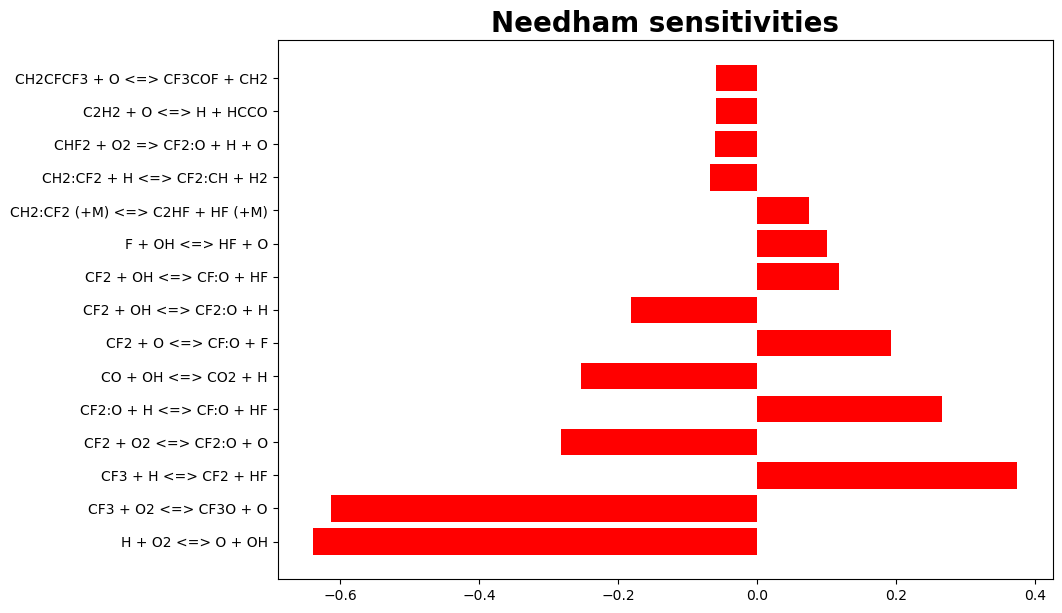

In [178]:
#Needham sensitivities
Needham_sens_path = '/work/westgroup/nora/Code/Advanced_Kinetics_Class/project/sensitivity/Needham_sensitivity/YF_Mech_Final.cti_sensitivities.csv'
df_Needham = pd.read_csv(Needham_sens_path)
top_sens = []

for index, row in df_Needham.iterrows():
    cantera_rxn_index, sens, cantera_equation, cantera_products, cantera_reactants = int(row[0]), float(row[1]), row[2], eval(row[3]), eval(row[4])
    sorted_cantera_reactants = dict(sorted(cantera_reactants.items()))
    sorted_cantera_products = dict(sorted(cantera_products.items()))
    if ((sorted_cantera_reactants,sorted_cantera_products)) in common_rxns_dictionaries_Needham:
        com_flag=True
    else:
        #print(((sorted_cantera_reactants,sorted_cantera_products)))
        com_flag=False
    

    
    
    top_sens.append((sens, cantera_equation, uniq_flag, com_flag))
    

    
plt.figure(figsize=(10,7))
temp=[] #for 
for sens, cantera_equation,uniq_flag, com_flag in top_sens[0:15]:
    #print(cantera_equation)
    
    if cantera_equation not in temp:
        temp.append(cantera_equation)
    else:
        cantera_equation = cantera_equation+' '
    plt.title('Needham sensitivities', fontsize = 20, fontweight='bold')
    plt.barh(cantera_equation, sens, color='r')
    print(cantera_equation, com_flag)

Is this true? 
# H + O2 <=> O + OH True
# CF3 + O2 <=> CF3O + O True
# CF3 + H <=> CF2 + HF False TRUE
# CF2 + O2 <=> CF2:O + O False TRUE
# CF2:O + H <=> CF:O + HF True
# CO + OH <=> CO2 + H True
# CF2 + O <=> CF:O + F False TRUE
# CF2 + OH <=> CF2:O + H False TRUE
# CF2 + OH <=> CF:O + HF False TRUE
# F + OH <=> HF + O True
# CH2:CF2 (+M) <=> C2HF + HF (+M) True
# CH2:CF2 + H <=> CF2:CH + H2 True
# CHF2 + O2 => CF2:O + H + O False FALSE  ***
# C2H2 + O <=> H + HCCO True
# CH2CFCF3 + O <=> CF3COF + CH2 False FALSE ****

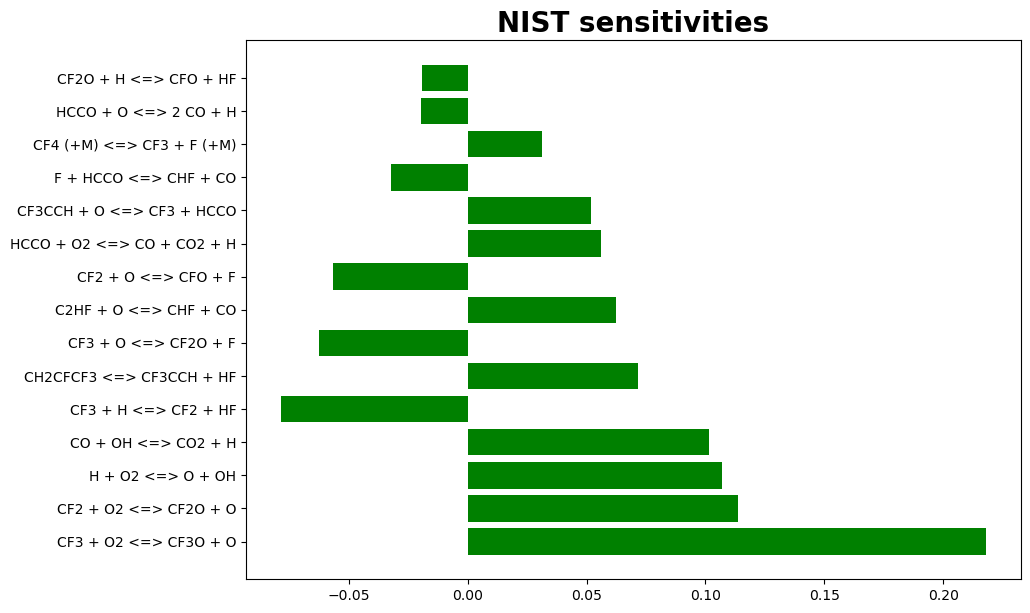

In [66]:
#NIST sensitivities
NIST_sens_path = '/work/westgroup/nora/Code/Advanced_Kinetics_Class/project/sensitivity/NIST_sensitivity/copy_frozen3_with_thermo.cti_sensitivities.csv'
df_NIST = pd.read_csv(NIST_sens_path)
top_sens = []

for index, row in df_NIST.iterrows():
    cantera_rxn_index, sens, cantera_equation, cantera_products, cantera_reactants = int(row[0]), float(row[1]), row[2], eval(row[3]), eval(row[4])
    top_sens.append((sens, cantera_equation))
    

    
plt.figure(figsize=(10,7))
temp=[] #for 
for sens, cantera_equation in top_sens[0:15]:
    #print(cantera_equation)
    
    if cantera_equation not in temp:
        temp.append(cantera_equation)
    else:
        cantera_equation = cantera_equation+' '
    plt.title('NIST sensitivities', fontsize = 20, fontweight='bold')
    plt.barh(cantera_equation, sens, color='g')
    
#which of these are in unique rxns:

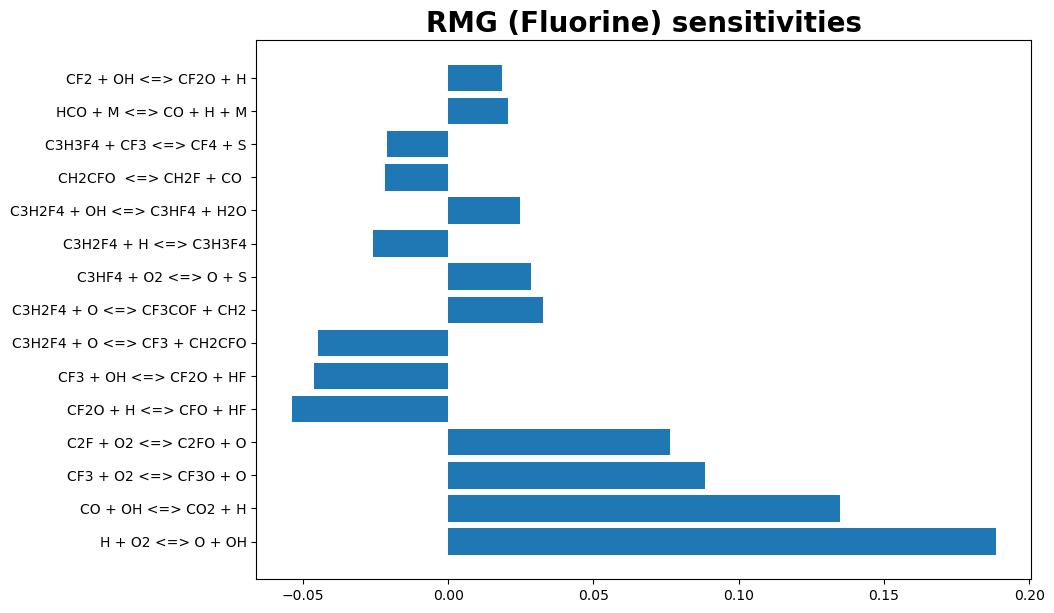

In [67]:
#RMG Fluorine sensitivities
RMG_F_sens_path = '/work/westgroup/nora/Code/Advanced_Kinetics_Class/project/sensitivity/RMG_Fluorine_lib/copy_chem_annotated_208.cti_sensitivities.csv'
df_RMG_F = pd.read_csv(RMG_F_sens_path)
top_sens = []

for index, row in df_RMG_F.iterrows():
    cantera_rxn_index, sens, cantera_equation, cantera_products, cantera_reactants = int(row[0]), float(row[1]), row[2], eval(row[3]), eval(row[4])
    top_sens.append((sens, cantera_equation))
    

    
plt.figure(figsize=(10,7))
temp=[] #for 
for sens, cantera_equation in top_sens[0:15]:
    #print(cantera_equation)
    
    if cantera_equation not in temp:
        temp.append(cantera_equation)
    else:
        cantera_equation = cantera_equation+' '
    results = re.findall('\(\S+\)', cantera_equation)
    for parenthesis in results:
        cantera_equation = cantera_equation.replace(parenthesis,'')
    plt.title('RMG (Fluorine) sensitivities', fontsize = 20, fontweight='bold')
    plt.barh(cantera_equation, sens, color='tab:blue')
    
#which of these are in unique rxns:

H(5) + O2(3) <=> O(6) + OH(2)
CF3(123) + H(5) <=> CF2(130) + HF(120)
CF3(123) + O2(3) <=> CF3O(135) + O(6)
C3H2F4(1) + F(118) <=> CF3(123) + S(142)
CF2O(129) + H(5) <=> CFO(126) + HF(120)
C3HF4(248) + O2(3) <=> O(6) + S(2811)
CF2(130) + O2(3) <=> CF2O(129) + O(6)
CF2(130) + OH(2) <=> CF2O(129) + H(5)
CF2(130) + O(6) <=> CFO(126) + F(118)
CO(11) + OH(2) <=> CO2(8) + H(5)
C2HF2(163) + CF3(123) <=> C2HF(137) + CF4(133)
CHF(121) + O2(3) <=> CFO2(872) + H(5)
C3H2F4(1) + OH(2) <=> C3HF4(175) + H2O(4)
CF2(130) + OH(2) <=> CFO(126) + HF(120)
CHF2(128) + O2(3) => CF2O(129) + H(5) + O(6)


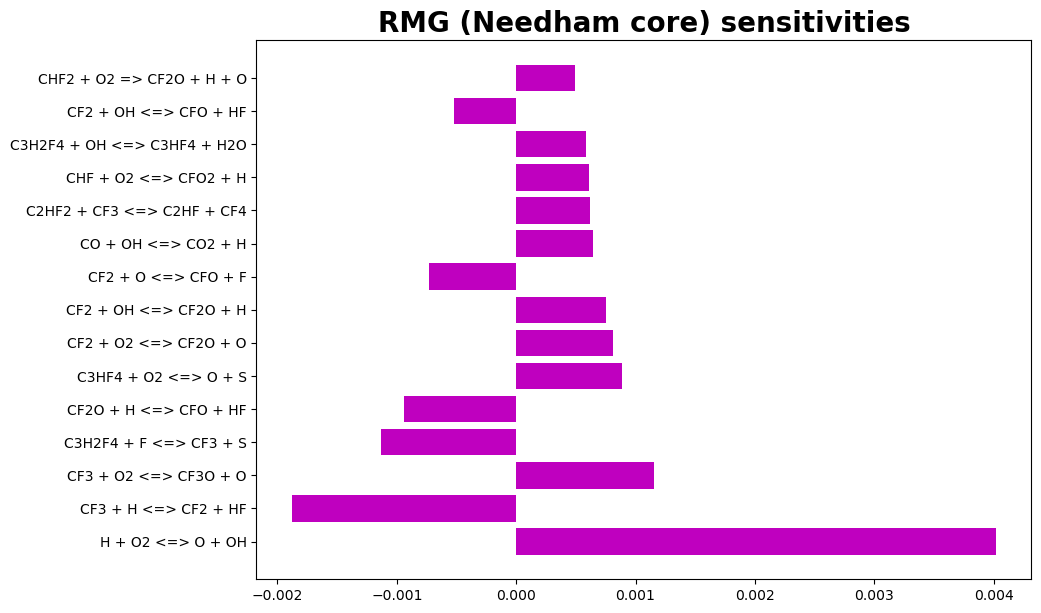

In [4]:
#RMG Needham Core

#
RMG_Nc_sens_path = '/work/westgroup/nora/Code/Advanced_Kinetics_Class/project/sensitivity/RMG_Needham_core/copy_chem_248_annotated.cti_sensitivities.csv'
df_RMG_Nc = pd.read_csv(RMG_Nc_sens_path)
top_sens = []

for index, row in df_RMG_Nc.iterrows():
    cantera_rxn_index, sens, cantera_equation, cantera_products, cantera_reactants = int(row[0]), float(row[1]), row[2], eval(row[3]), eval(row[4])
    top_sens.append((sens, cantera_equation))
    

    
plt.figure(figsize=(10,7))
temp=[] #for 
for sens, cantera_equation in top_sens[0:15]:
    print(cantera_equation)
    
    if cantera_equation not in temp:
        temp.append(cantera_equation)
    else:
        cantera_equation = cantera_equation+' '
    results = re.findall('\(\S+\)', cantera_equation)
    for parenthesis in results:
        cantera_equation = cantera_equation.replace(parenthesis,'')
    plt.title('RMG (Needham core) sensitivities', fontsize = 20, fontweight='bold')
    plt.barh(cantera_equation, sens, color='m')
    
#which of these are common to the Needham model:

# H(5) + O2(3) <=> O(6) + OH(2)  #  Library reaction: YF/full
# CF3(123) + H(5) <=> CF2(130) + HF(120) # Library reaction: YF/full
# CF3(123) + O2(3) <=> CF3O(135) + O(6) #  Library reaction: YF/full
# C3H2F4(1) + F(118) <=> CF3(123) + S(142) ##  Library reaction: YF/full
# CF2O(129) + H(5) <=> CFO(126) + HF(120) #  Library reaction: YF/full
# C3HF4(248) + O2(3) <=> O(6) + S(2811) ##  PDep reaction: PDepNetwork #3798
# CF2(130) + O2(3) <=> CF2O(129) + O(6) #  Library reaction: YF/full
# CF2(130) + OH(2) <=> CF2O(129) + H(5) #  Library reaction: YF/full
# CF2(130) + O(6) <=> CFO(126) + F(118) ##  Library reaction: YF/full
# CO(11) + OH(2) <=> CO2(8) + H(5) #  Library reaction: YF/full
# C2HF2(163) + CF3(123) <=> C2HF(137) + CF4(133) # #  Estimated from node Root_N-4R->F
# CHF(121) + O2(3) <=> CFO2(872) + H(5) ##  PDep reaction: PDepNetwork #2226
# C3H2F4(1) + OH(2) <=> C3HF4(175) + H2O(4) ##  Library reaction: YF/full
# CF2(130) + OH(2) <=> CFO(126) + HF(120) #  Library reaction: YF/full
# CHF2(128) + O2(3) => CF2O(129) + H(5) + O(6) #  Library reaction: YF/full